In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import(
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)

In [4]:
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers.winsorizer import Winsorizer

import mlflow

In [41]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

from sklearn.metrics import ConfusionMatrixDisplay

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

### Load the data

In [7]:
# read the csv file

df = pd.read_csv('titanic_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# checking for the missing values
(
    df
    .isna()
    .sum()
)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

`Age`, `Cabin` and `Embarked` has missing values

In [9]:
# info about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Data Cleaning

In [10]:
# columns to drop

columns_to_drop = ['passengerid','name','ticket','cabin']

In [11]:
def clean_data(df):
    return(
        df
        .rename(columns=str.lower)
        .drop(columns=columns_to_drop)
        .assign(
            family = lambda df_ : df_['sibsp'] + df_['parch']
        )
        .drop(columns=['sibsp', 'parch'])
    )

In [12]:
final_df = clean_data(df)
final_df.head()

,survived,pclass,sex,age,fare,embarked,family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [13]:
# shape of the clean data

print(f'The cleaned data has {final_df.shape[0]} rows and {final_df.shape[1]} columns')

The cleaned data has 891 rows and 7 columns


In [14]:
# checking the missing values in the cleaned data

(
    final_df
    .isna()
    .sum()
)

survived      0
pclass        0
sex           0
age         177
fare          0
embarked      2
family        0
dtype: int64

### EDA

In [15]:
# ditribution of target
(
    final_df
    .loc[:, 'survived']
    .value_counts(normalize=True)
)

survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

In [16]:
# boxplot

def create_boxplot(data, column_name, hue=None):
    sns.boxplot(data=data, y=column_name, hue=hue)

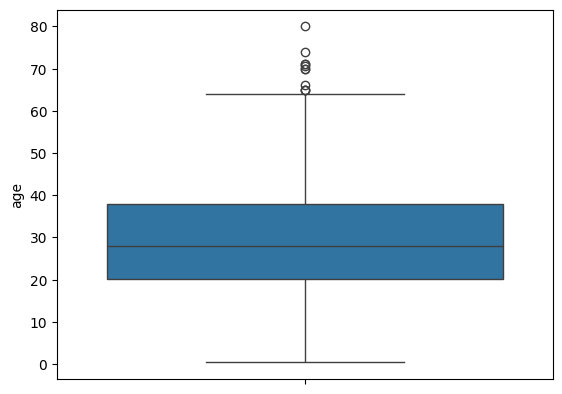

In [17]:
create_boxplot(final_df, 'age')

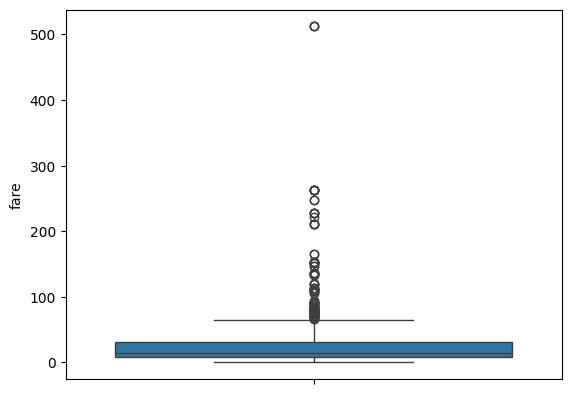

In [18]:
create_boxplot(final_df, 'fare')

#### overview 
- Outlier in age and fare cloumns

In [19]:
# plot the distribution of categorical columns

def plot_distribution(data, column_name):
    sns.countplot(data=data, x=column_name)

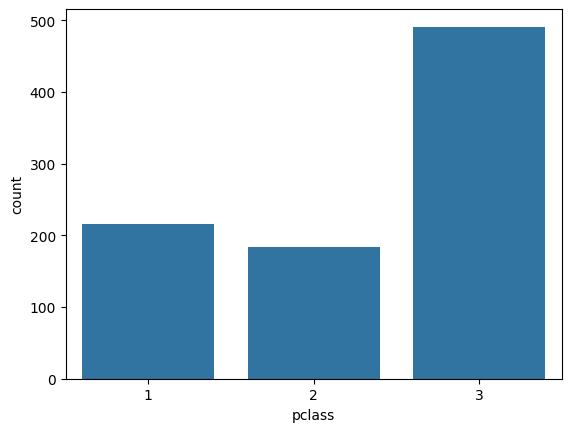

In [20]:
plot_distribution(final_df, "pclass")

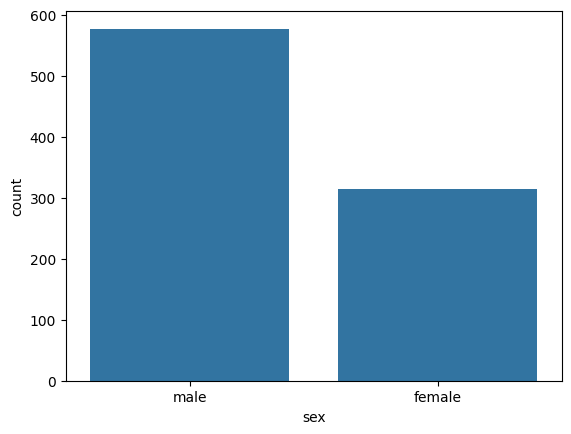

In [21]:
plot_distribution(final_df, "sex")

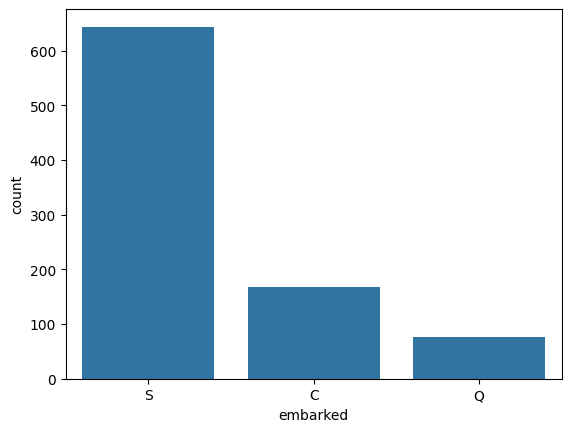

In [22]:
plot_distribution(final_df, "embarked")

### Feature Engineering

In [23]:
final_df.head()

,survived,pclass,sex,age,fare,embarked,family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [24]:
# making x and y

X = final_df.drop(columns=['survived'])
y = final_df['survived']

In [25]:
X.head()

,pclass,sex,age,fare,embarked,family
0,3,male,22.0,7.2500,S,1
1,1,female,38.0,71.2833,C,1
2,3,female,26.0,7.9250,S,0
3,1,female,35.0,53.1000,S,1
4,3,male,35.0,8.0500,S,0


In [26]:
# performing train test split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('The shape of training data :', x_train.shape)
print('The shape of testing data :', x_test.shape)

The shape of training data : (712, 6)
The shape of testing data : (179, 6)


### Pipeline for individual Columns

In [27]:
# age_pipeline

age_pip = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('outlier', Winsorizer(capping_method='gaussian', fold=3)),
    ('scale', StandardScaler())
])

age_pip

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('outlier', Winsorizer(fold=3)), ('scale', StandardScaler())])

In [28]:
# fare pipeline

fare_pipe = Pipeline(steps=[
    ('outlier', Winsorizer(capping_method="iqr", fold=1.5)),
    ('scale', StandardScaler())
])

fare_pipe

Pipeline(steps=[('outlier', Winsorizer(capping_method='iqr', fold=1.5)),
                ('scale', StandardScaler())])

In [29]:
# embarked pipeline

embarked_pip = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('count_encode', CountFrequencyEncoder(encoding_method='count')),
    ('scale', MinMaxScaler())
])

embarked_pip

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('count_encode', CountFrequencyEncoder()),
                ('scale', MinMaxScaler())])

### Column Transformation

In [30]:
set_config(transform_output="pandas")

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Assuming age_pip, fare_pipe, embarked_pip are defined elsewhere in your code

preprocessor = ColumnTransformer(
    transformers=[
        ('age', age_pip, ['age']),
        ('fare', fare_pipe, ['fare']),
        ('embarked', embarked_pip, ['embarked']),
        ('sex', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['sex']),
        ('family', MinMaxScaler(), ['family'])
    ],
    remainder='passthrough',  # Keeps all columns that are not explicitly mentioned
    n_jobs=-1  # Allows for parallel processing
)

preprocessor


ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('age',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('outlier',
                                                  Winsorizer(fold=3)),
                                                 ('scale', StandardScaler())]),
                                 ['age']),
                                ('fare',
                                 Pipeline(steps=[('outlier',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5)),
                                                 ('scale', StandardScaler())]),
                                 ['fare']),
                                ('embarked',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('count_encode',
                                                  CountFrequencyEncoder()),
                                                 ('scale', MinMaxScaler())]),
                                 ['embarked']),
                                ('sex',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['sex']),
                                ('family', MinMaxScaler(), ['family'])])

In [34]:
# fit and transform the training data

preprocessor.fit_transform(x_train)

,age__age,fare__fare,embarked__embarked,sex__sex_female,sex__sex_male,family__family,remainder__pclass
331,1.266850,0.236751,1.0,0.0,1.0,0.0,1
733,-0.478777,-0.532339,1.0,0.0,1.0,0.0,2
382,0.219474,-0.784153,1.0,0.0,1.0,0.0,3
704,-0.246027,-0.787666,1.0,0.0,1.0,0.1,3
813,-1.797695,0.374443,1.0,1.0,0.0,0.6,3
...,...,...,...,...,...,...,...
106,-0.633944,-0.797799,1.0,1.0,0.0,0.0,3
270,-0.090860,0.360798,1.0,0.0,1.0,0.0,1
860,0.917724,-0.477346,1.0,0.0,1.0,0.2,3
435,-1.177028,2.016201,1.0,1.0,0.0,0.3,1


In [35]:
# Define the classifier
clf = RandomForestClassifier(random_state=42)

In [36]:
# Create a pipeline that includes both preprocessing and the classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

In [37]:
# Fit the model on the training data
model_pipeline.fit(x_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outlier',
                                                                   Winsorizer(fold=3)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('fare',
                                                  Pipeline(steps=[('outlier',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['fare']),
                                                 ('embarked',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('count_encode',
                                                                   CountFrequencyEncoder()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [38]:
# Predict on the test data
y_pred = model_pipeline.predict(x_test)

In [39]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.8101
Precision: 0.7703
Recall: 0.7703
F1 Score: 0.7703


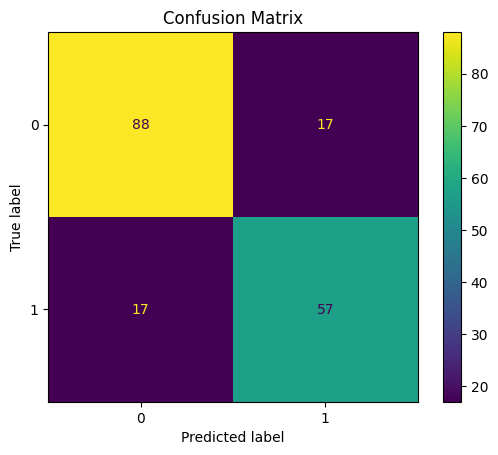

In [42]:
# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix')
plt.show()

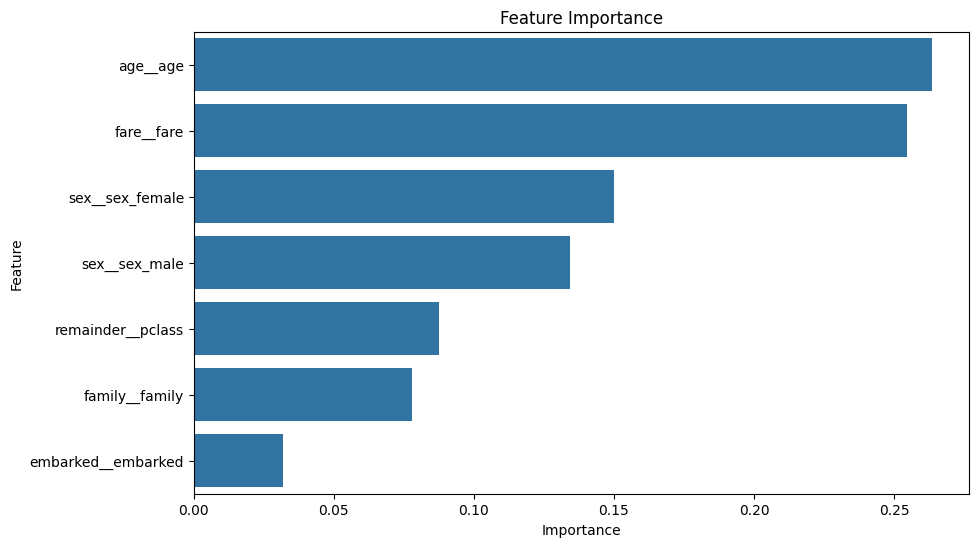

In [44]:
# Visualize feature importance if using RandomForestClassifier
if hasattr(model_pipeline.named_steps['classifier'], 'feature_importances_'):
    feature_importances = model_pipeline.named_steps['classifier'].feature_importances_
    feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance')
    plt.show()